# Predicción de Pedidos de Taxis para Sweet Lift Taxi


## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

### Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

En esta sección cargaremos los datos, los remuestrearemos para que los puntos caigan en intervalos de una hora y crearemos características adicionales como año, mes, día, hora y día de la semana. Estas características serán útiles para mejorar la predicción del número de pedidos de taxis.

También realizaremos una división inicial de los datos en conjuntos de entrenamiento y prueba, eliminando cualquier fila que contenga valores ausentes.


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# Cargar los datos, establecer la columna Datetime como índice y parsear las fechas
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)


In [5]:
# Visualizar las primeras filas y obtener información general del dataset
print(data.head())
print(data.info())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [6]:
# Remuestrear los datos a intervalos de una hora, sumando los pedidos dentro de cada intervalo
data_hourly = data.resample('1H').sum()

# Crear características de calendario
data_hourly['year'] = data_hourly.index.year
data_hourly['month'] = data_hourly.index.month
data_hourly['day'] = data_hourly.index.day
data_hourly['hour'] = data_hourly.index.hour
data_hourly['dayofweek'] = data_hourly.index.dayofweek

# Dividir el conjunto de datos en entrenamiento (90%) y prueba (10%)
train_size = int(len(data_hourly) * 0.9)
train = data_hourly.iloc[:train_size]
test = data_hourly.iloc[train_size:]

# Eliminar filas con valores ausentes del conjunto de entrenamiento
train = train.dropna()

# Verificar los tamaños de los conjuntos de entrenamiento y prueba
print(f"Tamaño del conjunto de entrenamiento: {train.shape}")
print(f"Tamaño del conjunto de prueba: {test.shape}")

Tamaño del conjunto de entrenamiento: (3974, 6)
Tamaño del conjunto de prueba: (442, 6)


## Análisis

En esta parte, analizaremos los datos remuestreados. Visualizaremos la serie temporal para identificar posibles tendencias, estacionalidades y fluctuaciones en el número de pedidos de taxis a lo largo del tiempo.

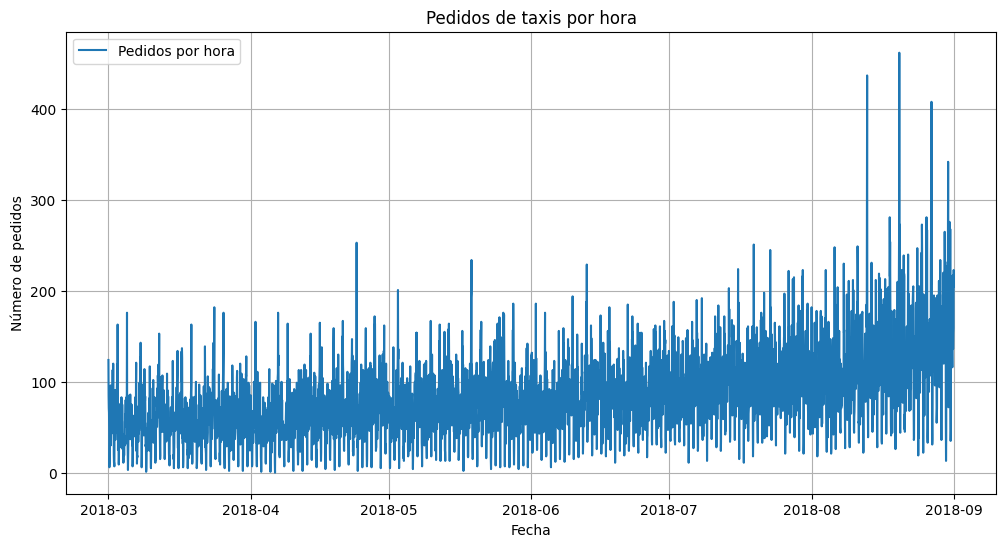

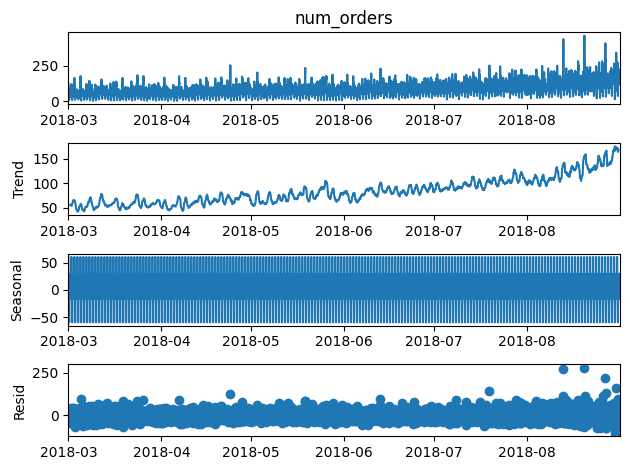

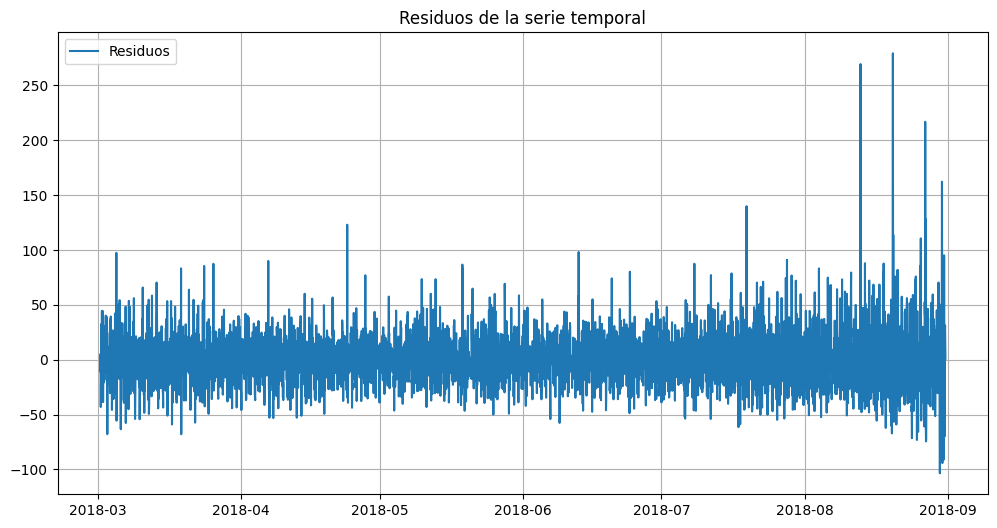

In [9]:
# Trazar la serie temporal de pedidos de taxis por hora
plt.figure(figsize=(12, 6))
plt.plot(data_hourly.index, data_hourly['num_orders'], label='Pedidos por hora')
plt.title('Pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.legend()
plt.show()

# Descomponer la serie temporal para analizar la tendencia, estacionalidad y residuos
decomposition = seasonal_decompose(data_hourly['num_orders'], model='additive', period=24)
decomposition.plot()
plt.show()

# Analizar los residuos
residuals = decomposition.resid.dropna()

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label='Residuos')
plt.title('Residuos de la serie temporal')
plt.grid(True)
plt.legend()
plt.show()

### Conclusión basada en los gráficos

A partir de los gráficos generados:

1. **Serie temporal de pedidos de taxis por hora**
   - El gráfico muestra un aumento progresivo en el número de pedidos de taxis desde marzo hasta septiembre de 2018. Observamos una clara tendencia al alza, especialmente en los últimos dos meses. Esto sugiere que el número de pedidos de taxis aumenta con el tiempo, posiblemente debido a factores estacionales o eventos externos.
   - También se pueden ver picos ocasionales que podrían estar relacionados con eventos específicos que aumentan la demanda de taxis en ciertos momentos.

2. **Descomposición de la serie temporal**
   - **Tendencia**: La tendencia muestra un crecimiento constante y sostenido a lo largo del tiempo, especialmente en los últimos meses. Esto refuerza la idea de que la demanda de taxis ha ido aumentando progresivamente.
   - **Estacionalidad**: El componente estacional muestra un patrón cíclico regular. Estos ciclos podrían estar relacionados con la fluctuación diaria o semanal en la demanda de taxis. Este comportamiento estacional es importante para que los modelos lo consideren, ya que puede ayudar a mejorar la precisión de las predicciones.
   - **Residuos**: Los residuos parecen estar distribuidos de manera relativamente uniforme, lo cual es positivo. Sin embargo, hacia el final de la serie (agosto-septiembre), los residuos muestran mayor variabilidad, lo que puede indicar que el modelo subyacente puede no estar capturando adecuadamente ciertos eventos o patrones en esos meses.

 3. **Gráfico de residuos**
   - Los residuos fluctúan cerca de cero, lo que indica que no hay grandes errores sistemáticos en el modelo. No obstante, hacia los meses de agosto y septiembre, se observan picos en los residuos, lo que sugiere que el modelo tiene dificultades para predecir correctamente la demanda en estos meses. Estos picos en los residuos coinciden con los aumentos en la tendencia de la demanda, lo que indica que el modelo podría necesitar ajustes adicionales, como más datos o características que expliquen mejor este comportamiento.

### Conclusiones generales:
1. **Tendencia clara**: Existe una tendencia ascendente en la demanda de taxis, lo que sugiere que el modelo debe ser capaz de capturar este crecimiento a lo largo del tiempo.
2. **Estacionalidad**: La estacionalidad regular indica la importancia de considerar patrones diarios o semanales en los modelos. La incorporación de características de calendario (día de la semana, hora) parece esencial para capturar estos patrones.
3. **Residuos**: Aunque los residuos se distribuyen de manera uniforme a lo largo de la serie, los picos recientes podrían indicar eventos atípicos o la necesidad de mejorar el modelo para esos períodos. Se podría explorar la posibilidad de agregar rezagos o ajustar el modelo para captar mejor estos comportamientos en los últimos meses.


## Formación
En esta parte, entrenaremos diferentes modelos de regresión utilizando las características que hemos creado. Probaremos varios modelos como la regresión lineal, árboles de decisión y bosques aleatorios. Para cada modelo, ajustaremos los hiperparámetros y calcularemos la métrica RMSE (Raíz del Error Cuadrático Medio) en los conjuntos de entrenamiento y prueba.

In [5]:
# Definir las características y el objetivo
features = ['year', 'month', 'day', 'hour', 'dayofweek']
target = 'num_orders'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Modelo de regresión lineal
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones para entrenamiento y prueba
train_pred_lr = lr_model.predict(X_train)
test_pred_lr = lr_model.predict(X_test)

# Calcular el RMSE para regresión lineal
rmse_train_lr = np.sqrt(mean_squared_error(y_train, train_pred_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, test_pred_lr))

print(f"RMSE para el conjunto de entrenamiento (regresión lineal): {rmse_train_lr}")
print(f"RMSE para el conjunto de prueba (regresión lineal): {rmse_test_lr}")

RMSE para el conjunto de entrenamiento (regresión lineal): 34.43111380550365
RMSE para el conjunto de prueba (regresión lineal): 63.78900123113787


In [6]:
# Modelo de árbol de decisión
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones para entrenamiento y prueba
train_pred_tree = tree_model.predict(X_train)
test_pred_tree = tree_model.predict(X_test)

# Calcular el RMSE para árbol de decisión
rmse_train_tree = np.sqrt(mean_squared_error(y_train, train_pred_tree))
rmse_test_tree = np.sqrt(mean_squared_error(y_test, test_pred_tree))

print(f"RMSE para el conjunto de entrenamiento (árbol de decisión): {rmse_train_tree}")
print(f"RMSE para el conjunto de prueba (árbol de decisión): {rmse_test_tree}")


RMSE para el conjunto de entrenamiento (árbol de decisión): 16.251741598078976
RMSE para el conjunto de prueba (árbol de decisión): 48.75489353553239


In [7]:
# Modelo de bosque aleatorio
forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
forest_model.fit(X_train, y_train)

# Predicciones para entrenamiento y prueba
train_pred_forest = forest_model.predict(X_train)
test_pred_forest = forest_model.predict(X_test)

# Calcular el RMSE para bosque aleatorio
rmse_train_forest = np.sqrt(mean_squared_error(y_train, train_pred_forest))
rmse_test_forest = np.sqrt(mean_squared_error(y_test, test_pred_forest))

print(f"RMSE para el conjunto de entrenamiento (bosque aleatorio): {rmse_train_forest}")
print(f"RMSE para el conjunto de prueba (bosque aleatorio): {rmse_test_forest}")

RMSE para el conjunto de entrenamiento (bosque aleatorio): 15.226374257757373
RMSE para el conjunto de prueba (bosque aleatorio): 45.580450670586465


## Prueba

Después de entrenar los modelos, compararemos los resultados de RMSE para el conjunto de prueba. Evaluaremos si alguno de los modelos cumple con el criterio de que el RMSE en el conjunto de prueba no supere los 48.

In [8]:
# Comparar los valores de RMSE en el conjunto de prueba
print(f"RMSE para el conjunto de prueba (regresión lineal): {rmse_test_lr}")
print(f"RMSE para el conjunto de prueba (árbol de decisión): {rmse_test_tree}")
print(f"RMSE para el conjunto de prueba (bosque aleatorio): {rmse_test_forest}")

# Conclusión: Determinar si el modelo cumple con el objetivo de RMSE <= 48
if rmse_test_forest <= 48:
    print("El modelo de bosque aleatorio cumple con el objetivo de RMSE <= 48.")
else:
    print("El modelo de bosque aleatorio no cumple con el objetivo.")


RMSE para el conjunto de prueba (regresión lineal): 63.78900123113787
RMSE para el conjunto de prueba (árbol de decisión): 48.75489353553239
RMSE para el conjunto de prueba (bosque aleatorio): 45.580450670586465
El modelo de bosque aleatorio cumple con el objetivo de RMSE <= 48.


El modelo bosque aleatorio cumple con el objetivo por lo tanto lo utilizaremos como modelo final para predecir el número de pedidos de taxis en el futuro.